In [2]:
import importlib
import os
from io import StringIO
from pathlib import Path
from pprint import pprint as pp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyadcirc.io as pio
import pyadcirc.utils as au
import xarray as xr
from cartopy import crs
from IPython.display import Image
from pyadcirc import noaa
import pyadcirc.figuregen as fg
from taccjm import taccjm as tjm

# import geoviews as gv
# import holoviews as hv
# from holoviews import opts

%matplotlib widget

In [3]:
# Viewing options configurations
# gv.extension("bokeh")
# gv.opts.defaults(
#     gv.opts.EdgePaths(width=700, height=700),
#     gv.opts.Image(width=700, height=700),
#     gv.opts.Points(width=700, height=700),
#     gv.opts.RGB(width=450, height=450),
# )

In [4]:
# Dir with this notebook resides
base_dir = Path(os.path.dirname(os.getcwd()))
data_dir = base_dir / "notebooks" / "data"
data_dir.mkdir(exist_ok=True)
base_dir, data_dir

(PosixPath('/Users/carlos/repos/pyadcirc'),
 PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data'))

In [5]:
# Pub dir paths on TACC. Should be accessible from all systems
pub_dir = Path("/work2/06307/clos21/pub")
adc_inputs = pub_dir / "adcirc" / "inputs"
adc_execs = pub_dir / "adcirc" / "execs"

# Path to input files for this notebooks ADCIRC run

In [6]:
jm = "l1"
system = "ls6"

## TACC Job Manager - Initialize


* Lets name our job manager instance `l1`. The name of the JM instance will dictate where all app, job, and other data generated by taccjm will be stored. 

* Choose system to run ADCIRC on - Here we choose ls6 - [Lonestar 6](https://portal.tacc.utexas.edu/user-guides/lonestar5)


In [7]:
# tjm.find_tjm_processes(kill=True)
jms = tjm.list_jms()
jms

[{'jm_id': 'l1',
  'sys': 'ls6.tacc.utexas.edu',
  'user': 'clos21',
  'apps_dir': '/scratch/06307/clos21/l1/apps',
  'jobs_dir': '/scratch/06307/clos21/l1/jobs'}]

In [8]:
if jm not in [j["jm_id"] for j in jms]:
    tjm.init_jm(jm, system)
else:
    print(f"{jm} already initialized:")
    pp(tjm.get_jm(jm))

l1 already initialized:
{'apps_dir': '/scratch/06307/clos21/l1/apps',
 'jm_id': 'l1',
 'jobs_dir': '/scratch/06307/clos21/l1/jobs',
 'scripts_dir': '/scratch/06307/clos21/l1/scripts',
 'sys': 'ls6.tacc.utexas.edu',
 'trash_dir': '/scratch/06307/clos21/l1/trash',
 'user': 'clos21'}


# Alaska Storms

Running and analyzing input/output for Feb2019 CSFv2 Wind+Ice forcing data run. Uses LW Alaska Mesh from Notre Dame group.

Notebooks sections

* Setup:
    * TACC Job Manager
    * ADCIRC Data
    * ADCIRC Executables
* Running
* Analyzing

## Alaska Region Variables

Below we specify regions of interest and ts of interest.

### Regions of interest

In [42]:
ak_bb = [162, 230, 40, 80]              
nome_bb = [187.3, 200.75, 61.35, 67.4]
yk_bb = [193, 200, 58, 64]

### Time-Stamps of Peak Storm Surges

In [43]:
feb2011_peak_ts = '2011-02-23 23:00:00'
nov2011_peak_ts = '2011-11-10 00:00:00'
jan2017_peak_ts = '2017-01-01 00:01:00'

# ADCIRC Runs Set-Up

## Meteorological Data

### Feb 2011 Wind+Ice CFSv2 Data w/LW AK Mesh

In [70]:
# Feb2011 Storm
feb2011_name = "AK_Feb2011_CFSv2"
feb2011_scan_base_input_path = adc_inputs / "Alaska/met/Feb2011/CFSv2/beta-base-lw"

feb2011_data_dir = data_dir / feb2011_name
feb2011_data_dir.mkdir(exist_ok=True)

In [71]:
tjm.list_files(jm, feb2011_scan_base_input_path)

[{'filename': 'fort.13'},
 {'filename': 'fort.221.nc'},
 {'filename': 'fort.225.nc'},
 {'filename': 'fort.24'},
 {'filename': 'fort.15'},
 {'filename': 'fort.222.nc'},
 {'filename': 'fort.14'},
 {'filename': 'fort.22'}]

Lets get the fort.14/fort.15 files and read configurations of run

In [72]:
feb2011_f14_path = feb2011_data_dir / "fort.14"
feb2011_f15_path = feb2011_data_dir / "fort.15"

In [73]:
feb2011_f15_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2011_CFSv2/fort.15')

In [74]:
if not feb2011_f15_path.exists():
    tjm.download(jm, feb2011_scan_base_input_path / "fort.15", feb2011_f15_path)
if not feb2011_f14_path.exists():
    tjm.download(jm, feb2011_scan_base_input_path / "fort.14", feb2011_f14_path)

In [75]:
feb2011_configs = pio.read_fort14(str(feb2011_f14_path), load_grid=False)
feb2011_configs = pio.read_fort15(str(feb2011_f15_path), ds=feb2011_configs)
feb2011_configs

<xarray.Dataset>
Dimensions:                (ELEV_BOUNDARY: 574, NORMAL_BOUNDARY: 37546,
                            NODAL_ATTRS: 4, TIPOTAG: 8, BOUNTAG: 8,
                            ALPHA: 4592, STATIONS: 27, STATIONS_VEL: 27,
                            STATIONS_MET: 27, NAMEFR: 8)
Coordinates:
  * ELEV_BOUNDARY          (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
  * NORMAL_BOUNDARY        (NORMAL_BOUNDARY) int64 0 0 0 0 0 ... 479 479 479 479
  * NODAL_ATTRS            (NODAL_ATTRS) <U42 'beta' ... 'advection_state'
  * TIPOTAG                (TIPOTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * BOUNTAG                (BOUNTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * ALPHA                  (ALPHA) object 'Q1' 'Q1' 'Q1' 'Q1' ... 'K2' 'K2' 'K2'
  * STATIONS               (STATIONS) int64 0 1 2 3 4 5 6 ... 21 22 23 24 25 26
  * STATIONS_VEL           (STATIONS_VEL) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * STATIONS_MET           (STATIONS_MET) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * NAMEFR                 (NAMEFR) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
Data variables: (12/23)
    IBTYPEE                (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ELEV_BOUNDARY_NODES    (ELEV_BOUNDARY) int64 380573 380571 ... 3621 3351
    IBTYPE                 (NORMAL_BOUNDARY) int64 20 20 20 20 ... 21 21 21 21
    NORMAL_BOUNDARY_NODES  (NORMAL_BOUNDARY) int64 139030 139031 ... 335404
    TPK                    (TIPOTAG) float64 0.0193 0.1008 ... 0.1133 0.03078
    AMIGT                  (TIPOTAG) float64 6.496e-05 6.76e-05 ... 0.0001458
    ...                     ...
    YEV                    (STATIONS_VEL) float64 55.33 56.25 ... 67.58 70.41
    XEM                    (STATIONS_MET) float64 228.4 225.4 ... 195.9 211.5
    YEM                    (STATIONS_MET) float64 55.33 56.25 ... 67.58 70.41
    HAFREQ                 (NAMEFR) float64 6.496e-05 6.76e-05 ... 0.0001458
    HAFF                   (NAMEFR) float64 0.9559 0.9749 ... 0.9994 0.9455
    HAFACE                 (NAMEFR) float64 225.9 171.9 60.47 ... 359.9 77.98
Attributes: (12/100)
    AGRID:         Mindo's Alaska mesh
    NE:            850855
    NP:            443770
    NOPE:          2
    NETA:          574
    NBOU:          480
    ...            ...
    NCCOM:         Comments: Used for thesis research
    NCHOST:        Host: Name
    NCCONV:        Metric, MSL
    NCCONT:        carlos.delcastillo@utexas.edu
    NCDATE:        2011-02-01 00:00:00 UTC
    CONTROL_LIST:  ['! -- Begin met Control Namelist --', '&metControl', 'Win...

### Nov 2011 Wind+Ice CFSv2 Data w/LW AK Mesh

In [76]:
# Feb2011 Storm
nov2011_storm_name = "AK_Nov2011_CFSv2"
nov2011_scan_base_input_path = adc_inputs / "Alaska/met/Nov2011/CFSv2/beta-base-lw"

nov2011_data_dir = data_dir / nov2011_storm_name
nov2011_data_dir.mkdir(exist_ok=True)

In [77]:
tjm.list_files(jm, nov2011_scan_base_input_path)

[{'filename': 'fort.13'},
 {'filename': 'fort.221.nc'},
 {'filename': 'fort.225.nc'},
 {'filename': 'fort.24'},
 {'filename': 'fort.15'},
 {'filename': 'fort.222.nc'},
 {'filename': 'fort.14'},
 {'filename': 'fort.22'}]

Lets get the fort.14/fort.15 files and read configurations of run

In [53]:
nov2011_f14_path = nov2011_data_dir / "fort.14"
nov2011_f15_path = nov2011_data_dir / "fort.15"

In [78]:
if not nov2011_f15_path.exists():
    tjm.download(jm, nov2011_scan_base_input_path / "fort.15", nov2011_f15_path)
if not nov2011_f14_path.exists():
    tjm.download(jm, nov2011_scan_base_input_path / "fort.14", nov2011_f14_path)

In [79]:
nov2011_configs = pio.read_fort14(str(nov2011_f14_path), load_grid=False)
nov2011_configs = pio.read_fort15(str(nov2011_f15_path), ds=nov2011_configs)
nov2011_configs

<xarray.Dataset>
Dimensions:                (ELEV_BOUNDARY: 574, NORMAL_BOUNDARY: 37546,
                            NODAL_ATTRS: 4, TIPOTAG: 8, BOUNTAG: 8,
                            ALPHA: 4592, STATIONS: 27, STATIONS_VEL: 27,
                            STATIONS_MET: 27, NAMEFR: 8)
Coordinates:
  * ELEV_BOUNDARY          (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
  * NORMAL_BOUNDARY        (NORMAL_BOUNDARY) int64 0 0 0 0 0 ... 479 479 479 479
  * NODAL_ATTRS            (NODAL_ATTRS) <U42 'beta' ... 'advection_state'
  * TIPOTAG                (TIPOTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * BOUNTAG                (BOUNTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * ALPHA                  (ALPHA) object 'Q1' 'Q1' 'Q1' 'Q1' ... 'K2' 'K2' 'K2'
  * STATIONS               (STATIONS) int64 0 1 2 3 4 5 6 ... 21 22 23 24 25 26
  * STATIONS_VEL           (STATIONS_VEL) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * STATIONS_MET           (STATIONS_MET) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * NAMEFR                 (NAMEFR) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
Data variables: (12/23)
    IBTYPEE                (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ELEV_BOUNDARY_NODES    (ELEV_BOUNDARY) int64 380573 380571 ... 3621 3351
    IBTYPE                 (NORMAL_BOUNDARY) int64 20 20 20 20 ... 21 21 21 21
    NORMAL_BOUNDARY_NODES  (NORMAL_BOUNDARY) int64 139030 139031 ... 335404
    TPK                    (TIPOTAG) float64 0.0193 0.1008 ... 0.1133 0.03078
    AMIGT                  (TIPOTAG) float64 6.496e-05 6.76e-05 ... 0.0001458
    ...                     ...
    YEV                    (STATIONS_VEL) float64 55.33 56.25 ... 67.58 70.41
    XEM                    (STATIONS_MET) float64 228.4 225.4 ... 195.9 211.5
    YEM                    (STATIONS_MET) float64 55.33 56.25 ... 67.58 70.41
    HAFREQ                 (NAMEFR) float64 6.496e-05 6.76e-05 ... 0.0001458
    HAFF                   (NAMEFR) float64 0.9559 0.9749 ... 0.9994 0.9455
    HAFACE                 (NAMEFR) float64 225.9 171.9 60.47 ... 359.9 77.98
Attributes: (12/100)
    AGRID:         Mindo's Alaska mesh
    NE:            850855
    NP:            443770
    NOPE:          2
    NETA:          574
    NBOU:          480
    ...            ...
    NCCOM:         Comments: Used for thesis research
    NCHOST:        Host: Name
    NCCONV:        Metric, MSL
    NCCONT:        carlos.delcastillo@utexas.edu
    NCDATE:        2011-10-25 00:00:00 UTC
    CONTROL_LIST:  ['! -- Begin met Control Namelist --', '&metControl', 'Win...

### Jan 2017 Wind+Ice CFSv2 Data w/LW AK Mesh

In [60]:
# Feb2011 Storm
jan2017_storm_name = "AK_jan2017_CFSv2"
jan2017_scan_base_input_path = adc_inputs / "Alaska/met/Jan2017/CFSv2/beta-base-lw"

jan2017_data_dir = data_dir / jan2017_storm_name
jan2017_data_dir.mkdir(exist_ok=True)

In [61]:
tjm.list_files(jm, jan2017_scan_base_input_path)

[{'filename': 'fort.13'},
 {'filename': 'fort.221.nc'},
 {'filename': 'fort.225.nc'},
 {'filename': 'fort.24'},
 {'filename': 'fort.15'},
 {'filename': 'fort.222.nc'},
 {'filename': 'fort.14'},
 {'filename': 'fort.22'}]

Lets get the fort.14/fort.15 files and read configurations of run

In [62]:
jan2017_f14_path = jan2017_data_dir / "fort.14"
jan2017_f15_path = jan2017_data_dir / "fort.15"

In [80]:
if not jan2017_f14_path.exists():
    tjm.download(jm, jan2017_scan_base_input_path / "fort.15", jan2017_f15_path)
if not jan2017_f14_path.exists():
    tjm.download(jm, jan2017_scan_base_input_path / "fort.14", jan2017_f14_path)

In [81]:
jan2017_configs = pio.read_fort14(str(jan2017_f14_path), load_grid=False)
jan2017_configs = pio.read_fort15(str(jan2017_f15_path), ds=jan2017_configs)
jan2017_configs

<xarray.Dataset>
Dimensions:                (ELEV_BOUNDARY: 574, NORMAL_BOUNDARY: 37546,
                            NODAL_ATTRS: 4, TIPOTAG: 8, BOUNTAG: 8,
                            ALPHA: 4592, STATIONS: 27, STATIONS_VEL: 27,
                            STATIONS_MET: 27, NAMEFR: 8)
Coordinates:
  * ELEV_BOUNDARY          (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
  * NORMAL_BOUNDARY        (NORMAL_BOUNDARY) int64 0 0 0 0 0 ... 479 479 479 479
  * NODAL_ATTRS            (NODAL_ATTRS) <U42 'beta' ... 'advection_state'
  * TIPOTAG                (TIPOTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * BOUNTAG                (BOUNTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * ALPHA                  (ALPHA) object 'Q1' 'Q1' 'Q1' 'Q1' ... 'K2' 'K2' 'K2'
  * STATIONS               (STATIONS) int64 0 1 2 3 4 5 6 ... 21 22 23 24 25 26
  * STATIONS_VEL           (STATIONS_VEL) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * STATIONS_MET           (STATIONS_MET) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * NAMEFR                 (NAMEFR) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
Data variables: (12/23)
    IBTYPEE                (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ELEV_BOUNDARY_NODES    (ELEV_BOUNDARY) int64 380573 380571 ... 3621 3351
    IBTYPE                 (NORMAL_BOUNDARY) int64 20 20 20 20 ... 21 21 21 21
    NORMAL_BOUNDARY_NODES  (NORMAL_BOUNDARY) int64 139030 139031 ... 335404
    TPK                    (TIPOTAG) float64 0.0193 0.1008 ... 0.1133 0.03078
    AMIGT                  (TIPOTAG) float64 6.496e-05 6.76e-05 ... 0.0001458
    ...                     ...
    YEV                    (STATIONS_VEL) float64 55.33 56.25 ... 67.58 70.41
    XEM                    (STATIONS_MET) float64 228.4 225.4 ... 195.9 211.5
    YEM                    (STATIONS_MET) float64 55.33 56.25 ... 67.58 70.41
    HAFREQ                 (NAMEFR) float64 6.496e-05 6.76e-05 ... 0.0001458
    HAFF                   (NAMEFR) float64 0.9559 0.9749 ... 0.9994 0.9455
    HAFACE                 (NAMEFR) float64 225.9 171.9 60.47 ... 359.9 77.98
Attributes: (12/100)
    AGRID:         Mindo's Alaska mesh
    NE:            850855
    NP:            443770
    NOPE:          2
    NETA:          574
    NBOU:          480
    ...            ...
    NCCOM:         Comments: Used for thesis research
    NCHOST:        Host: Name
    NCCONV:        Metric, MSL
    NCCONT:        carlos.delcastillo@utexas.edu
    NCDATE:        2016-12-15 00:00:00 UTC
    CONTROL_LIST:  ['! -- Begin met Control Namelist --', '&metControl', 'Win...

### Feb 2019 Wind+Ice CFSv2 Data w/LW AK Mesh

We will be using the data in from met folder in Alaska corresponding to Feb2019 CSFv2 Data:

In [102]:
# Feb2019 Storm
feb2019_storm_name = "AK_Feb2019"
feb2019_scan_base_input_path = adc_inputs / "Alaska" / "met" / "Feb2019" / "CFSv2" / "base-lw"

In [103]:
feb2019_data_dir = data_dir / feb2019_storm_name
feb2019_data_dir.mkdir(exist_ok=True)

In [104]:
tjm.list_files(jm, feb2019_scan_base_input_path)

[{'filename': 'fort.13'},
 {'filename': 'fort.225'},
 {'filename': 'fort.24'},
 {'filename': 'fort.15'},
 {'filename': 'fort.222'},
 {'filename': 'fort.14'},
 {'filename': 'fort.221'},
 {'filename': 'fort.25'},
 {'filename': 'fort.22'}]

Lets get the fort.14/fort.15 files and read configurations of run

In [105]:
feb2019_f14_path = feb2019_data_dir / "fort.14"
feb2019_f15_path = feb2019_data_dir / "fort.15"
feb2019_f14_path.exists()

False

In [106]:
if not feb2019_f15_path.exists():
    tjm.download(jm, feb2019_scan_base_input_path / "fort.15", feb2019_f15_path)
if not feb2019_f14_path.exists():
    tjm.download(jm, feb2019_scan_base_input_path / "fort.14", feb2019_f14_path)

In [107]:
feb2019_configs = pio.read_fort14(str(feb2019_f14_path), load_grid=False)
feb2019_configs = pio.read_fort15(str(feb2019_f15_path), ds=feb2019_configs)
feb2019_configs

<xarray.Dataset>
Dimensions:                (ELEV_BOUNDARY: 574, NORMAL_BOUNDARY: 37546,
                            NODAL_ATTRS: 4, TIPOTAG: 8, BOUNTAG: 8,
                            ALPHA: 4592, STATIONS: 27, STATIONS_VEL: 27,
                            STATIONS_MET: 27, NAMEFR: 8)
Coordinates:
  * ELEV_BOUNDARY          (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
  * NORMAL_BOUNDARY        (NORMAL_BOUNDARY) int64 0 0 0 0 0 ... 479 479 479 479
  * NODAL_ATTRS            (NODAL_ATTRS) <U42 'beta' ... 'advection_state'
  * TIPOTAG                (TIPOTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * BOUNTAG                (BOUNTAG) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
  * ALPHA                  (ALPHA) object 'Q1' 'Q1' 'Q1' 'Q1' ... 'K2' 'K2' 'K2'
  * STATIONS               (STATIONS) int64 0 1 2 3 4 5 6 ... 21 22 23 24 25 26
  * STATIONS_VEL           (STATIONS_VEL) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * STATIONS_MET           (STATIONS_MET) int64 0 1 2 3 4 5 ... 22 23 24 25 26
  * NAMEFR                 (NAMEFR) object 'Q1' 'O1' 'P1' ... 'M2' 'S2' 'K2'
Data variables: (12/23)
    IBTYPEE                (ELEV_BOUNDARY) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ELEV_BOUNDARY_NODES    (ELEV_BOUNDARY) int64 380573 380571 ... 3621 3351
    IBTYPE                 (NORMAL_BOUNDARY) int64 20 20 20 20 ... 21 21 21 21
    NORMAL_BOUNDARY_NODES  (NORMAL_BOUNDARY) int64 139030 139031 ... 335404
    TPK                    (TIPOTAG) float64 0.0193 0.1008 ... 0.1133 0.03078
    AMIGT                  (TIPOTAG) float64 6.496e-05 6.76e-05 ... 0.0001458
    ...                     ...
    YEV                    (STATIONS_VEL) float64 55.33 56.25 ... 67.58 70.41
    XEM                    (STATIONS_MET) float64 228.4 225.4 ... 195.9 211.5
    YEM                    (STATIONS_MET) float64 55.33 56.25 ... 67.58 70.41
    HAFREQ                 (NAMEFR) float64 6.496e-05 6.76e-05 ... 0.0001458
    HAFF                   (NAMEFR) float64 0.9559 0.9749 ... 0.9994 0.9455
    HAFACE                 (NAMEFR) float64 225.9 171.9 60.47 ... 359.9 77.98
Attributes: (12/100)
    AGRID:         Mindo's Alaska mesh
    NE:            850855
    NP:            443770
    NOPE:          2
    NETA:          574
    NBOU:          480
    ...            ...
    NCCOM:         Comments: Used for thesis research
    NCHOST:        Host: Name
    NCCONV:        Metric, MSL
    NCCONT:        carlos.delcastillo@utexas.edu
    NCDATE:        2019-02-01 00:00:00 UTC
    CONTROL_LIST:  ['! -- Begin met Control Namelist --', '&metControl', 'Win...

Met forcing files can be quite large. Lets not download them, just take a peak at the first line.

We know since NWS value in fort.15 config is :

In [108]:
feb2019_configs.attrs["NWS"]

12012

This means data is in OWI format (see https://wiki.adcirc.org/wiki/NWS for more on NWS param).

So first line should contain date range we are working with

In [109]:
# OceanWeather Data format
date_range = [
    x
    for x in tjm.peak_file(jm, feb2019_scan_base_input_path / "fort.221", head=1)[:-1].split(" ")
    if x != ""
][-2:]
date_range

['2019020100', '2019030100']

## Control File - fort.15 

First we download locally 

Modifications to make:

* Make NCDATE line up with start of meteorological data date
* Set recording stations to NOAA Alaska Area recording stations.
* Set desired frequency of recording at stations


In [38]:
configs.attrs["NCDATE"] = "2019-02-01 00:00:00 UTC"
configs.attrs["NCDATE"]

'2019-02-01 00:00:00 UTC'

#### Adding NOAA Stations

Get NOAA Tide Stations to use for recording stations in ADCIRC run using utility function `get_f15_stations`

Copy and paste the output of the function to appropriate sections after NSTAE,NSTAV,NSTAM lines.

In [90]:
importlib.reload(noaa)

<module 'pyadcirc.noaa' from '/Users/carlos/repos/pyadcirc/src/pyadcirc/noaa.py'>

In [96]:
f15_stations_txt = noaa.get_f15_stations("Alaska")

Getting NOAA station 9450460.0 - Ketchikan, AK
Getting NOAA station 9451054.0 - Port Alexander, AK
Getting NOAA station 9451600.0 - Sitka, AK
Getting NOAA station 9452210.0 - Juneau, AK
Getting NOAA station 9452400.0 - Skagway, Taiya Inlet, AK
Getting NOAA station 9452634.0 - Elfin Cove, AK
Getting NOAA station 9453220.0 - Yakutat, Yakutat Bay, AK
Getting NOAA station 9454050.0 - Cordova, AK
Getting NOAA station 9454240.0 - Valdez, AK
Getting NOAA station 9455090.0 - Seward, AK
Getting NOAA station 9455500.0 - Seldovia, AK
Getting NOAA station 9455760.0 - Nikiski, AK
Getting NOAA station 9455920.0 - Anchorage, AK
Getting NOAA station 9457292.0 - Kodiak Island, AK
Getting NOAA station 9457804.0 - Alitak, AK
Getting NOAA station 9459450.0 - Sand Point, AK
Getting NOAA station 9459881.0 - King Cove, AK
Getting NOAA station 9461380.0 - Adak Island, AK
Getting NOAA station 9461710.0 - Atka, AK
Getting NOAA station 9462450.0 - Nikolski, AK
Getting NOAA station 9462620.0 - Unalaska, AK
Gettin

In [ ]:
print(f15_stations_txt)

#### Re-uploading fort.15 file

If changed the local f15 file, then re-upload to directory.

In [1]:
# tjm.upload(jm, f15_path, input_path / "fort.15")

## Executables - ADCIRC Version

Choose for appropriate TACC System:

In [27]:
tjm.list_files(jm, adc_execs)

[{'filename': 'ls6'}, {'filename': 'stampede2'}]

Choose appropriate version:

In [139]:
tjm.list_files(jm, adc_execs / "ls6")

[{'filename': 'v55_nodal_beta'}, {'filename': 'v55.01'}]

Verify executables exist:

In [29]:
# Lonestar6 v55.01 execs
ls6_v55_path = adc_execs / "ls6" / "v55.01"
tjm.list_files(jm, ls6_v55_path)

[{'filename': 'padcirc'}, {'filename': 'adcprep'}]

In [146]:
# Lonestar6 v55.01 execs
ls6_dev = adc_execs / "ls6" / "development"
tjm.list_files(jm, ls6_dev)

[{'filename': 'padcirc'}, {'filename': 'padcswan'}, {'filename': 'adcprep'}]

### Building ADCIRC Versions

Requires: Github credentials set-up on remote system.

Access to [adcirc-cg](https://github.com/cdelcastillo21/adcirc-cg?organization=cdelcastillo21&organization=cdelcastillo21) repo.

Will be using TACC Job Manager to deploy and run an ADCIRC Compile script


TODO: Fix bugs in run_script with args.
Improve compile script to allow:
    Specifying destination directory
    Specifying output directory

In [208]:
tjm.list_scripts(jm)

['adcirc_compile']

In [211]:
tjm.deploy_script(jm, script_name=str(base_dir / "scripts/adcirc_compile.sh"))

In [311]:
# Fix bug: https://github.com/cdelcastillo21/taccjm/issues/10
# For now just ran this command on ls6 manually to build v55.01 and v55_nodal_beta branches
# res = tjm.run_script(jm, 'adcirc_compile', args=["v55_nodal_beta", "https://github.com/cdelcastillo21/adcirc-cg.git"])
res = tjm.run_script(
    jm,
    "adcirc_compile",
    args=["v55_beta_gm", "https://github.com/cdelcastillo21/adcirc-cg.git"],
)
# res = tjm.run_script(jm, 'adcirc_compile', args=["v55.01", "https://github.com/cdelcastillo21/adcirc-cg.git", "1"])
# res = tjm.run_script(jm, 'adcirc_compile', args=["development", "https://github.com/adcirc/adcirc-cg.git"])
# res = tjm.run_script(jm, 'adcirc_compile', args=["v56_beta", "https://github.com/cdelcastillo21/adcirc-cg.git"])
log = pd.read_csv(StringIO(res), delimiter="|")
log

Wed Jun  8 14:03:14 CDT 2022    ADCIRC_COMPILE    INFO   \
0  Wed Jun  8 14:03:23 CDT 2022    ADCIRC_COMPILE    INFO    
1  Wed Jun  8 14:03:24 CDT 2022    ADCIRC_COMPILE    INFO    
2  Wed Jun  8 14:03:25 CDT 2022    ADCIRC_COMPILE    INFO    
3  Wed Jun  8 14:03:36 CDT 2022    ADCIRC_COMPILE    INFO    
4  Wed Jun  8 14:05:27 CDT 2022    ADCIRC_COMPILE    INFO    
5  Wed Jun  8 14:05:27 CDT 2022    ADCIRC_COMPILE    INFO    

                                 Cloning ADCIRC Repo  
0   Updating ADCIRC repo https://github.com/cdelc...  
1                                Checking out branch  
2               Checked out v55_beta_gm successfully  
3                       cmake configuration complete  
4                                      make complete  
5                                Copying executables

# Single ADCIRC Run Jobs

Here we go over the details of running ADCIRC 

In [15]:
tjm.list_apps(jm)

['ls6_adcirc--0.0.0', 'pylauncher--0.0.0']

In [16]:
tjm.get_app(jm, "ls6_adcirc--0.0.0")

{'name': 'ls6_adcirc--0.0.0',
 'short_desc': 'General purpose adcirc application for ls6.',
 'long_desc': '',
 'default_node_count': 1,
 'default_processors_per_node': 10,
 'default_memory_per_node': '1',
 'default_max_run_time': '00:10:00',
 'default_queue': 'development',
 'entry_script': 'run.sh',
 'inputs': [],
 'parameters': [{'name': 'inputDirectory',
   'label': 'Input Directory',
   'desc': 'The directory containing ADCIRC input files.'},
  {'name': 'execDirectory',
   'label': 'Executables Directory',
   'desc': 'The directory containing ADCIRC executables to use.'},
  {'name': 'writeProcesses',
   'label': 'Number of Write Processes',
   'desc': 'Number of processes to dedicate to writing output data.'}],
 'outputs': [{'name': 'Outputs',
   'label': 'Output Directory',
   'desc': 'Directory containing output to archive.'}]}

In [117]:
allocs = tjm.get_allocations(jm)
alloc = allocs[0]["name"]
allocs

[{'name': 'ADCIRC', 'service_units': 59838, 'exp_date': '2023-03-31'},
 {'name': 'DMS21038', 'service_units': 10607, 'exp_date': '2022-12-31'}]

## Job 1 - Feb2011 Base Run

### Configure job 

Configure inputs

In [31]:
# Lonestar6 v55.01 execs
ls6_v55_beta = adc_execs / "ls6" / "v55_nodal_beta"
tjm.list_files(jm, ls6_v55_beta)

[{'filename': 'padcirc'}, {'filename': 'padcswan'}, {'filename': 'adcprep'}]

In [32]:
# Set execs_dir for future cells to use
in_dir_1 = feb2011_scan_base_input_path
execs_dir_1 = ls6_v55_beta
write_proc_1 = 2
node_count_1 = 1
proc_per_node_1 = 128
rt_1 = "00:45:00"

In [24]:
job_config_1 = {
    "name": "beta-ak_lw_feb2011_CFSv2-wind+ice",
    "app": "ls6_adcirc--0.0.0",
    "desc": "".join(
        [
            "ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55",
            " branch implementing nodal beta parameter for ice parametrization.",
        ]
    ),
    "queue": "normal",
    "node_count": node_count_1,
    "processors_per_node": proc_per_node_1,
    "max_run_time": rt_1,
    "allocation": alloc,
}
job_config_1["inputs"] = {}
job_config_1["parameters"] = {
    "inputDirectory": f"{in_dir_1}",
    "execDirectory": f"{execs_dir_1}",
    "writeProcesses": write_proc_1,
}
pp(job_config_1)

{'allocation': 'DMS21038',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'inputs': {},
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base',
                'writeProcesses': 4},
 'processors_per_node': 45,
 'queue': 'normal'}


### Deploy Job 


In [25]:
deployed_1 = tjm.deploy_job(jm, job_config=job_config_1)
pp(deployed_1)

{'allocation': 'DMS21038',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_141801',
 'job_id': 'beta-ak_lw_feb2019_wind+ice_20220608_141801',
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base',
                'writeProcesses': 4},
 'processors_per_node': 45,
 'queue': 'normal'}


In [26]:
# Note list_job_files not working at the  moment
tjm.list_files(jm, deployed_1["job_dir"])

[{'filename': 'test'},
 {'filename': 'job.json'},
 {'filename': 'run.sh'},
 {'filename': 'app.json'},
 {'filename': 'submit_script.sh'}]

### Running Job

Now we can submit the job to run on the execution queue

In [27]:
submitted_1 = tjm.submit_job(jm, deployed_1["job_id"])

In [28]:
pp(submitted_1)

{'allocation': 'DMS21038',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_141801',
 'job_id': 'beta-ak_lw_feb2019_wind+ice_20220608_141801',
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base',
                'writeProcesses': 4},
 'processors_per_node': 45,
 'queue': 'normal',
 'slurm_id': '231232'}


### Checking job status

In [29]:
tjm.get_queue(jm)

[{'job_id': '231232',
  'job_name': 'beta-ak_lw',
  'username': 'clos21',
  'state': 'Running',
  'nodes': '1',
  'remaining': '1',
  'start_time': '0:44:43'}]

In [30]:
job_dir_1 = submitted_1["job_dir"]
job_dir_1

'/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_141801'

We can also look at job files 

For example for adcirc runs we can look for an adcirc.log file (provided the appropriate setting is set in fort.15 file to output to log file)

In [31]:
job_files_1 = tjm.list_files(jm, submitted_1["job_dir"], attrs=["st_size"])
# job_files.sort()
tjm._print_res(job_files_1, fields=["filename"], search="filename", match=r"^fort.9")
# [j for j in job_files if not j.startswith("PE")]

+----------+
| filename |
+----------+
+----------+


In [46]:
job_files_1 = tjm.list_files(jm, submitted_1["job_dir"], attrs=["st_size"])
# job_files.sort()
tjm._print_res(job_files_1, fields=["filename"], search="filename", match=r"^output")
# [j for j in job_files if not j.startswith("PE")]

+---------------+
|    filename   |
+---------------+
| output.eo.txt |
+---------------+


And we can peak at the end of the file to see how long the run is going

In [79]:
print(tjm.peak_file(jm, str(Path(submitted_1["job_dir"]) / "output.eo.txt"), tail=20))

 TIME STEP =  126000  89.06% COMPLETE     ITERATIONS =   21     TIME =  0.25200000E+07
  ELMAX = -1.5448E-001 AT NODE     3967  SPEEDMAX =  5.3240E-001 AT NODE      247  ON MYPROC =    0
 TIME STEP =  127800  90.33% COMPLETE     ITERATIONS =   19     TIME =  0.25560000E+07
  ELMAX = -2.1925E-001 AT NODE     3716  SPEEDMAX =  4.0675E-001 AT NODE      131  ON MYPROC =    0
 TIME STEP =  129600  91.60% COMPLETE     ITERATIONS =   21     TIME =  0.25920000E+07
  ELMAX =  4.3842E-001 AT NODE       25  SPEEDMAX =  5.9101E-001 AT NODE     2395  ON MYPROC =    0
 TIME STEP =  131400  92.88% COMPLETE     ITERATIONS =   20     TIME =  0.26280000E+07
  ELMAX = -4.8428E-001 AT NODE       22  SPEEDMAX =  8.9119E-001 AT NODE       30  ON MYPROC =    0
 TIME STEP =  133200  94.15% COMPLETE     ITERATIONS =   17     TIME =  0.26640000E+07
  ELMAX =  3.5183E-001 AT NODE     2765  SPEEDMAX =  1.1195E+000 AT NODE      101  ON MYPROC =    0
 TIME STEP =  135000  95.42% COMPLETE     ITERATIONS =   21     T

In [53]:
print(
    tjm.peak_file(
        jm,
        str(
            Path(submitted_1["job_dir"])
            / f"{submitted_1['job_id']}.e{submitted_1['slurm_id']}"
        ),
        tail=10,
    )
)

+ PCORES=41
+ log INFO 'ADCIRC will run on a total of 45 cores, 41 for computation, 4 for data otuput'
++ date
+ echo 'Wed Jun  8 14:18:14 CDT 2022 : INFO - ADCIRC will run on a total of 45 cores, 41 for computation, 4 for data otuput'
+ printf '41\n1\nfort.14\n'
+ adcprep
+ printf '41\n2\n'
+ adcprep
+ ls -lat
+ ibrun -np 45 ./padcirc -W 4



In [52]:
print(
    tjm.peak_file(
        jm,
        str(
            Path(submitted_1["job_dir"])
            / f"{submitted_1['job_id']}.o{submitted_1['slurm_id']}"
        ),
        tail=10,
    )
)

lrwx------  1 clos21 G-800588       79 Jun  8 14:18 fort.221.nc -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.221.nc
lrwx------  1 clos21 G-800588       79 Jun  8 14:18 fort.222.nc -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.222.nc
lrwx------  1 clos21 G-800588       79 Jun  8 14:18 fort.225.nc -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.225.nc
lrwx------  1 clos21 G-800588       75 Jun  8 14:18 fort.24 -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.24
lrwx------  1 clos21 G-800588       63 Jun  8 14:18 padcirc -> /work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta/padcirc
-rwx------  1 clos21 G-800588     1173 Jun  8 14:18 submit_script.sh
drwx------  3 clos21 G-800588        3 Jun  8 14:18 test
-rw-------  1 clos21 G-800588      806 Jun  8 14:18 app.json
-rwx------  1 clos21 G-800588     1738 Jun  8 14:18 run.sh
drwx------ 57 clos21 G-800588       55 Jun  8 1

## Job 2

### Configure job 

Configure inputs

In [33]:
# Lonestar6 v55.01 execs
v55_beta_gm = adc_execs / "ls6" / "v55_beta_gm"
tjm.list_files(jm, v55_beta_gm)

[{'filename': 'padcirc'}, {'filename': 'padcswan'}, {'filename': 'adcprep'}]

In [36]:
# Set execs_dir for future cells to use
in_dir_2 = input_path
execs_dir_2 = v55_beta_gm
write_proc_2 = 4
node_count_2 = 1
proc_per_node_2 = 45
rt_2 = "00:45:00"

In [37]:
job_config_2 = {
    "name": "beta-ak_lw_feb2019_wind+ice",
    "app": "ls6_adcirc--0.0.0",
    "desc": "ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55 branch implementing nodal beta parameter for ice parametrization.",
    "queue": "normal",
    "node_count": node_count_2,
    "processors_per_node": proc_per_node_2,
    "max_run_time": rt_2,
    "allocation": alloc,
}
job_config_2["inputs"] = {}
job_config_2["parameters"] = {
    "inputDirectory": f"{in_dir_2}",
    "execDirectory": f"{execs_dir_2}",
    "writeProcesses": write_proc_2,
}
pp(job_config_2)

{'allocation': 'DMS21038',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'inputs': {},
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base',
                'writeProcesses': 4},
 'processors_per_node': 45,
 'queue': 'normal'}


### Deploy Job 


In [38]:
deployed_2 = tjm.deploy_job(jm, job_config=job_config_2)
pp(deployed_2)

{'allocation': 'DMS21038',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_142008',
 'job_id': 'beta-ak_lw_feb2019_wind+ice_20220608_142008',
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base',
                'writeProcesses': 4},
 'processors_per_node': 45,
 'queue': 'normal'}


In [39]:
# Note list_job_files not working at the  moment
tjm.list_files(jm, deployed_2["job_dir"])

[{'filename': 'test'},
 {'filename': 'app.json'},
 {'filename': 'job.json'},
 {'filename': 'run.sh'},
 {'filename': 'submit_script.sh'}]

### Running Job

Now we can submit the job to run on the execution queue

In [40]:
submitted_2 = tjm.submit_job(jm, deployed_2["job_id"])

In [41]:
pp(submitted_2)

{'allocation': 'DMS21038',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_142008',
 'job_id': 'beta-ak_lw_feb2019_wind+ice_20220608_142008',
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base',
                'writeProcesses': 4},
 'processors_per_node': 45,
 'queue': 'normal',
 'slurm_id': '231233'}


### Checking job status

In [42]:
tjm.get_queue(jm)

[{'job_id': '231232',
  'job_name': 'beta-ak_lw',
  'username': 'clos21',
  'state': 'Running',
  'nodes': '1',
  'remaining': '1',
  'start_time': '0:42:43'},
 {'job_id': '231233',
  'job_name': 'beta-ak_lw',
  'username': 'clos21',
  'state': 'Running',
  'nodes': '1',
  'remaining': '1',
  'start_time': '0:44:54'}]

In [43]:
job_dir_2 = submitted_2["job_dir"]
job_dir_2

'/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_142008'

We can also look at job files 

For example for adcirc runs we can look for an adcirc.log file (provided the appropriate setting is set in fort.15 file to output to log file)

In [44]:
job_files_2 = tjm.list_files(jm, submitted_2["job_dir"], attrs=["st_size"])
# job_files.sort()
tjm._print_res(job_files_2, fields=["filename"], search="filename", match=r"^fort.9")
# [j for j in job_files if not j.startswith("PE")]

+------------+
|  filename  |
+------------+
| fort.93.nc |
| fort.91.nc |
+------------+


In [56]:
job_files_2 = tjm.list_files(jm, submitted_2["job_dir"], attrs=["st_size"])
# job_files.sort()
tjm._print_res(job_files_2, fields=["filename"], search="filename", match=r"^output")
# [j for j in job_files if not j.startswith("PE")]

+---------------+
|    filename   |
+---------------+
| output.eo.txt |
+---------------+


And we can peak at the end of the file to see how long the run is going

In [80]:
print(tjm.peak_file(jm, str(Path(submitted_2["job_dir"]) / "output.eo.txt"), tail=20))

 TIME STEP =  126000  89.06% COMPLETE     ITERATIONS =   21     TIME =  0.25200000E+07
  ELMAX = -1.5448E-001 AT NODE     3967  SPEEDMAX =  5.3240E-001 AT NODE      247  ON MYPROC =    0
 TIME STEP =  127800  90.33% COMPLETE     ITERATIONS =   19     TIME =  0.25560000E+07
  ELMAX = -2.1925E-001 AT NODE     3716  SPEEDMAX =  4.0675E-001 AT NODE      131  ON MYPROC =    0
 TIME STEP =  129600  91.60% COMPLETE     ITERATIONS =   21     TIME =  0.25920000E+07
  ELMAX =  4.3842E-001 AT NODE       25  SPEEDMAX =  5.9101E-001 AT NODE     2395  ON MYPROC =    0
 TIME STEP =  131400  92.88% COMPLETE     ITERATIONS =   20     TIME =  0.26280000E+07
  ELMAX = -4.8428E-001 AT NODE       22  SPEEDMAX =  8.9119E-001 AT NODE       30  ON MYPROC =    0
 TIME STEP =  133200  94.15% COMPLETE     ITERATIONS =   17     TIME =  0.26640000E+07
  ELMAX =  3.5183E-001 AT NODE     2765  SPEEDMAX =  1.1195E+000 AT NODE      101  ON MYPROC =    0
 TIME STEP =  135000  95.42% COMPLETE     ITERATIONS =   21     T

## Job 3

In [120]:
# Set execs_dir for future cells to use
in_dir_3 = adc_inputs / "Alaska/met/Feb2011/CFSv2/beta-base-test"
execs_dir_3 = v55_beta_gm
write_proc_3 = 4
node_count_3 = 1
proc_per_node_3 = 128
rt_3 = "00:45:00"

In [131]:
job_config_3 = {
    "name": "beta-ak_lw_feb2019_wind+ice",
    "app": "ls6_adcirc--0.0.0",
    "desc": "".join(
        [
            "ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55",
            " branch implementing nodal beta parameter for ice parametrization.",
        ]
    ),
    "queue": "normal",
    "node_count": node_count_3,
    "processors_per_node": proc_per_node_3,
    "max_run_time": rt_3,
    "allocation": alloc,
}
job_config_3["inputs"] = {}
job_config_3["parameters"] = {
    "inputDirectory": f"{in_dir_3}",
    "execDirectory": f"{execs_dir_3}",
    "writeProcesses": write_proc_3,
}
pp(job_config_3)

{'allocation': 'ADCIRC',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'inputs': {},
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/beta-base-test',
                'writeProcesses': 4},
 'processors_per_node': 128,
 'queue': 'normal'}


### Deploy Job 


In [132]:
deployed_3 = tjm.deploy_job(jm, job_config=job_config_3)
pp(deployed_3)

{'allocation': 'ADCIRC',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_172947',
 'job_id': 'beta-ak_lw_feb2019_wind+ice_20220608_172947',
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/beta-base-test',
                'writeProcesses': 4},
 'processors_per_node': 128,
 'queue': 'normal'}


In [133]:
# Note list_job_files not working at the  moment
tjm.list_files(jm, deployed_3["job_dir"])

[{'filename': 'test'},
 {'filename': 'app.json'},
 {'filename': 'job.json'},
 {'filename': 'run.sh'},
 {'filename': 'submit_script.sh'}]

### Running Job

Now we can submit the job to run on the execution queue

In [134]:
submitted_3 = tjm.submit_job(jm, deployed_3["job_id"])

In [135]:
pp(submitted_3)

{'allocation': 'ADCIRC',
 'app': 'ls6_adcirc--0.0.0',
 'desc': 'ADCIRC LW Mesh on LS6 with Feb2011 CFSv2 wind and ice data using v55 '
         'branch implementing nodal beta parameter for ice parametrization.',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_172947',
 'job_id': 'beta-ak_lw_feb2019_wind+ice_20220608_172947',
 'max_run_time': '00:45:00',
 'name': 'beta-ak_lw_feb2019_wind+ice',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/beta-base-test',
                'writeProcesses': 4},
 'processors_per_node': 128,
 'queue': 'normal',
 'slurm_id': '231587'}


### Checking job status

In [141]:
tjm.get_queue(jm)

[{'job_id': '231587',
  'job_name': 'beta-ak_lw',
  'username': 'clos21',
  'state': 'Running',
  'nodes': '1',
  'remaining': '1',
  'start_time': '0:44:16'}]

In [130]:
job_dir_3 = submitted_3["job_dir"]
job_dir_3

'/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220608_172303'

We can also look at job files 

For example for adcirc runs we can look for an adcirc.log file (provided the appropriate setting is set in fort.15 file to output to log file)

In [143]:
job_files_3 = tjm.list_files(jm, submitted_3["job_dir"], attrs=["st_size"])
# job_files.sort()
tjm._print_res(job_files_3, fields=["filename"], search="filename", match=r"^fort.9")
# [j for j in job_files if not j.startswith("PE")]

+------------+
|  filename  |
+------------+
| fort.93.nc |
| fort.91.nc |
+------------+


In [142]:
job_files_3 = tjm.list_files(jm, submitted_3["job_dir"], attrs=["st_size"])
# job_files.sort()
tjm._print_res(job_files_3, fields=["filename"], search="filename", match=r"^output")
# [j for j in job_files if not j.startswith("PE")]

+----------+
| filename |
+----------+
+----------+


And we can peak at the end of the file to see how long the run is going

In [145]:
print(tjm.peak_file(jm, str(Path(submitted_3["job_dir"]) / "adcprep.eo.txt"), tail=20))

  
 memory currently allocated =    887209071  bytes
 memory high water mark     =   1440462876  bytes
  
File fort.24 
 WAS FOUND!  Opening & Processing file.

  
 memory currently allocated =    887209071  bytes
 memory high water mark     =   1440462876  bytes
  
 Writing domain-decomposition file for post-processor
 
 INFO: Finished pre-processing input files.
  
  
 memory currently allocated =    887209071  bytes
 memory high water mark     =   1440462876  bytes
  
 ADCPREP COMPLETED



In [149]:
print(tjm.peak_file(jm, str(Path(submitted_3["job_dir"]) / "adcirc.eo.txt"), tail=30))

cat: '/proc/fs/lustre/llite/work*/stats': No such file or directory
cat: /proc/sys/lnet/stats: No such file or directory
 TIME STEP =   19800  91.67% COMPLETE     ITERATIONS =   23     TIME =  0.39600000E+06
  ELMAX =  3.6610E-001 AT NODE     2806  SPEEDMAX =  1.4834E+000 AT NODE     2171  ON MYPROC =    0
 TIME STEP =   21600 100.00% COMPLETE     ITERATIONS =   19     TIME =  0.43200000E+06
  ELMAX =  6.0565E-001 AT NODE     3737  SPEEDMAX =  4.7303E-001 AT NODE     1405  ON MYPROC =    0
cat: '/proc/fs/lustre/mdc/work*/stats': No such file or directory
cat: '/proc/fs/lustre/llite/work*/stats': No such file or directory
cat: '/proc/fs/lustre/llite/work*/stats': No such file or directory
cat: /proc/sys/lnet/stats: No such file or directory
 MPI terminated with Status =            0
TACC:  Shutdown complete. Exiting. 
Runtime error (func=(main), adr=9): Divide by zero
Runtime error (func=(main), adr=9): Divide by zero
Runtime error (func=(main), adr=9): Divide by zero


================

In [77]:
print(
    tjm.peak_file(
        jm,
        str(
            Path(submitted_3["job_dir"])
            / f"{submitted_3['job_id']}.e{submitted_3['slurm_id']}"
        ),
        tail=10,
    )
)

+ PCORES=41
+ log INFO 'ADCIRC will run on a total of 45 cores, 41 for computation, 4 for data otuput'
++ date
+ echo 'Wed Jun  8 14:47:14 CDT 2022 : INFO - ADCIRC will run on a total of 45 cores, 41 for computation, 4 for data otuput'
+ printf '41\n1\nfort.14\n'
+ adcprep
+ printf '41\n2\n'
+ adcprep
+ ls -lat
+ remora ibrun -np 45 ./padcirc -W 4



In [78]:
print(
    tjm.peak_file(
        jm,
        str(
            Path(submitted_3["job_dir"])
            / f"{submitted_3['job_id']}.o{submitted_3['slurm_id']}"
        ),
        tail=10,
    )
)

lrwx------  1 clos21 G-800588       79 Jun  8 14:47 fort.221.nc -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.221.nc
lrwx------  1 clos21 G-800588       79 Jun  8 14:47 fort.222.nc -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.222.nc
lrwx------  1 clos21 G-800588       79 Jun  8 14:47 fort.225.nc -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.225.nc
lrwx------  1 clos21 G-800588       75 Jun  8 14:47 fort.24 -> /work2/06307/clos21/pub/adcirc/inputs/Alaska/met/Feb2011/CFSv2/base/fort.24
lrwx------  1 clos21 G-800588       60 Jun  8 14:47 padcirc -> /work2/06307/clos21/pub/adcirc/execs/ls6/v55_beta_gm/padcirc
-rwx------  1 clos21 G-800588     1170 Jun  8 14:47 submit_script.sh
drwx------  3 clos21 G-800588        3 Jun  8 14:47 test
-rw-------  1 clos21 G-800588      806 Jun  8 14:47 app.json
-rwx------  1 clos21 G-800588     1745 Jun  8 14:47 run.sh
drwx------ 59 clos21 G-800588       57 Jun  8 14:4

In [113]:
res = tjm.download(
    jm, f"{submitted_3['job_dir']}/remora_231290", str(ak_data_dir / "remora")
)
res

# Analyze Output

In [10]:
# Old
# v55_wind_ice_run_dir = Path(
#     "/scratch/06307/clos21/l1/jobs/ak_lw_feb2019_wind+ice_20220207_220322"
# )
# v55_wind_ice_run_dir = Path(
#     "/scratch/06307/clos21/l1/jobs/ak_lw_feb2019_wind+ice_20220208_153527"
# )
# v55 = Path("/scratch/06307/clos21/l1/jobs/ak_lw_feb2019_wind+ice_20220208_163943")
# v55_beta = Path(
#     "/scratch/06307/clos21/l1/jobs/beta-ak_lw_feb2019_wind+ice_20220209_090339"
# )

v55_nodal_path = Path(submitted_1["job_dir"])
v55_nodal_gm_path = Path(submitted_2["job_dir"])

NameError: name 'submitted_1' is not defined

In [90]:
def list_adc_run_files(run_dir):
    """
    Quick utility to list none PE* files in run dir.
    """
    job_files = tjm.list_files(jm, run_dir)
    job_files.sort()
    job_files = [j for j in job_files if not j.startswith("PE")]
    return job_files

In [91]:
def get_file(run_dir, f, name=None):
    """
    Quick utility to download job file to local notebook folder
    """
    name = f if name is None else name
    remote_path = run_dir / f
    local_path = ak_data_dir / name
    tjm.download(jm, remote_path, local_path)
    return local_path

## F61 - Station Elevation Time Series

### v55 - beta param modification

In [93]:
f61_path = get_file(v55_nodal_path, "fort.61.nc", "fort.61.nc")
f61_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2011_CFSv2/fort.61.nc')

In [94]:
f61 = xr.open_dataset(f61_path)
f61

<xarray.Dataset>
Dimensions:       (time: 3600, station: 27)
Coordinates:
  * time          (time) datetime64[ns] 2011-02-11T00:06:00 ... 2011-02-26
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-12-gbd9ffbf
    grid_type:          Triangular
    description:        OceanMesh2D
    ...                 ...
    sfea0:              58.643293
    cf:                 0.0015
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               8

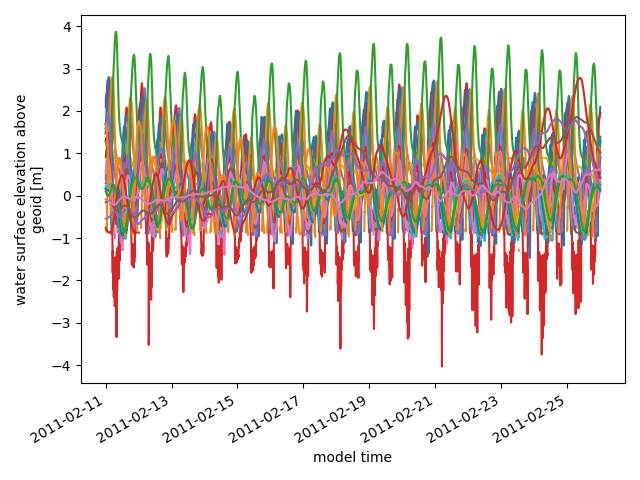

In [95]:
# This plot should show variability across every station
# Also no unreasonably high values (>4m across all stations)
fig, ax = plt.subplots(1, 1)
for s in range(len(f61["station_name"])):
    f61.isel(station=s)["zeta"].plot(ax=ax)
fig.tight_layout()

### v55 - beta

In [97]:
f61_beta_path = get_file(v55_beta, "fort.61.nc", "beta-fort.61.nc")
f61_beta_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2011_CFSv2/beta-fort.61.nc')

In [56]:
f61_beta = xr.open_dataset(f61_beta_path)
f61_beta

<xarray.Dataset>
Dimensions:       (time: 3600, station: 27)
Coordinates:
  * time          (time) datetime64[ns] 2019-02-11T00:06:00 ... 2019-02-26
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        OceanMesh2D
    ...                 ...
    sfea0:              58.643293
    cf:                 0.0015
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               8

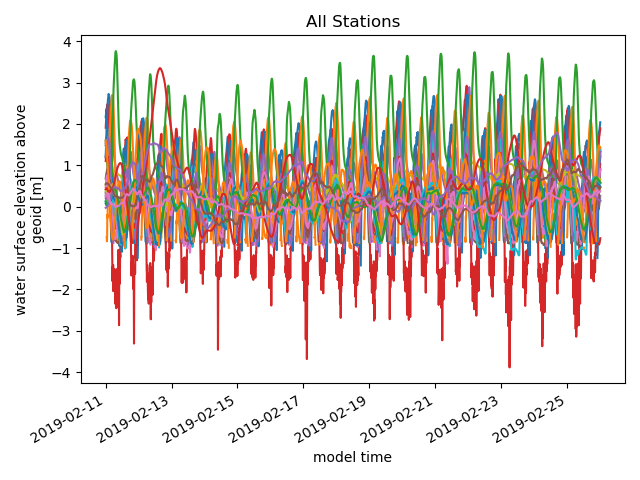

In [75]:
# This plot should show variability across every station
# Also no unreasonably high values (>4m across all stations)
fig, ax = plt.subplots(1, 1)
for s in range(len(f61_beta["station_name"])):
    f61_beta.isel(station=s)["zeta"].plot(ax=ax)
ax.set_title("All Stations")
fig.tight_layout()

### v55 - beta param mods + gm changes

In [98]:
f61_gm_path = get_file(v55_nodal_gm_path, "fort.61.nc", "beta-fort.61.nc")
f61_gm_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2011_CFSv2/beta-fort.61.nc')

In [99]:
f61_beta = xr.open_dataset(f61_gm_path)
f61_beta

<xarray.Dataset>
Dimensions:       (time: 3600, station: 27)
Coordinates:
  * time          (time) datetime64[ns] 2011-02-11T00:05:40 ... 2011-02-25T23...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-220-g84d0ee8
    grid_type:          Triangular
    description:        OceanMesh2D
    ...                 ...
    sfea0:              58.643293
    cf:                 0.0015
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               8

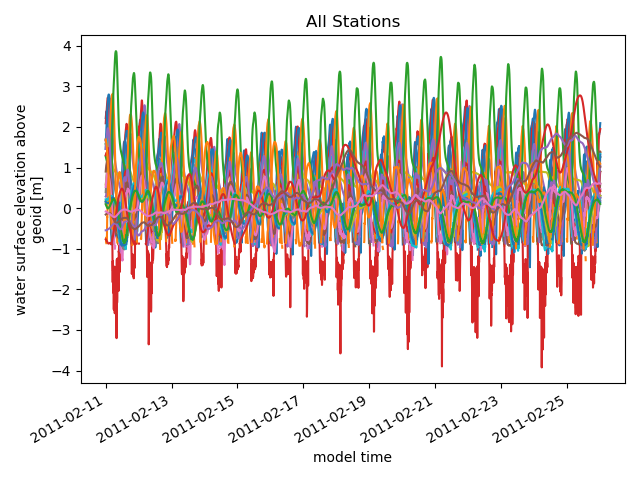

In [100]:
# This plot should show variability across every station
# Also no unreasonably high values (>4m across all stations)
fig, ax = plt.subplots(1, 1)
for s in range(len(f61_beta["station_name"])):
    f61_beta.isel(station=s)["zeta"].plot(ax=ax)
ax.set_title("All Stations")
fig.tight_layout()

### NOAA Station Comparison


In [2]:
station_idx = 24

In [3]:
station_id = (
    f61["station_name"].values[station_idx].decode("utf-8").strip().split(" ")[2]
)
station_id = int(float(station_id))
station_id

NameError: name 'f61' is not defined

In [103]:
noaa_station = noaa.get_station_metadata(station_id)
noaa_station

{'name': 'Nome, Norton Sound',
 'id': 9468756,
 'coords': [194.560361, 64.494611]}

In [104]:
start_date = f61["time"].to_pandas()[0].strftime("%Y%m%d %H:%M")
end_date = f61["time"].to_pandas()[-1].strftime("%Y%m%d %H:%M")
start_date, end_date

('20110211 00:06', '20110226 00:00')

In [105]:
noaa_data = noaa.get_station_data(station_id, start_date, end_date)
noaa_data

<xarray.DataArray 'water_levels' (time: 3600)>
array([-0.537, -0.545, -0.542, ...,  0.416,  0.402,  0.378])
Coordinates:
  * time     (time) datetime64[ns] 2011-02-11T00:06:00 ... 2011-02-26
Attributes:
    url:      https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?
    params:   {'begin_date': '20110211 00:06', 'end_date': '20110226 00:00', ...

In [1]:
noaa_data

NameError: name 'noaa_data' is not defined

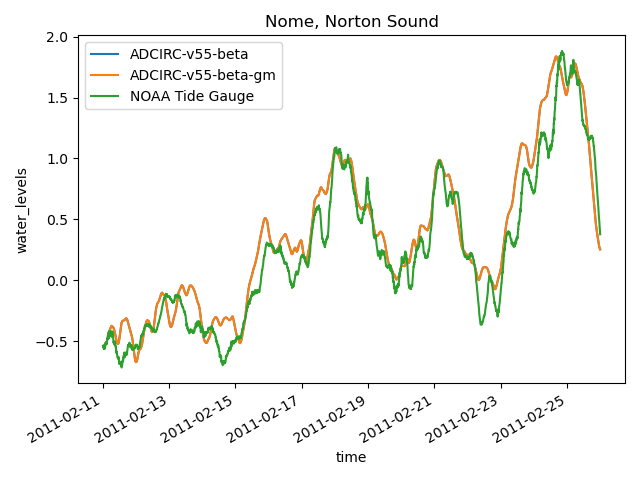

In [107]:
fig, ax = plt.subplots(1, 1)
f61.isel(station=station_idx)["zeta"].plot(ax=ax, label="ADCIRC-v55-beta")
f61_beta.isel(station=station_idx)["zeta"].plot(ax=ax, label="ADCIRC-v55-beta-gm")
noaa_data.plot(ax=ax, label="NOAA Tide Gauge")
ax.legend()
ax.set_title(f"{noaa_station['name']}")
fig.tight_layout()

## F62 - Station Water Column Depth Averaged Velocity

In [69]:
f62_path = get_file(v55, "fort.62.nc", "fort.62.nc")
f62_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2019/fort.62.nc')

In [70]:
f62 = xr.open_dataset(f62_path)
f62

<xarray.Dataset>
Dimensions:       (time: 3600, station: 27)
Coordinates:
  * time          (time) datetime64[ns] 2019-02-11T00:06:00 ... 2019-02-26
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    u-vel         (time, station) float64 ...
    v-vel         (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        OceanMesh2D
    ...                 ...
    sfea0:              58.643293
    cf:                 0.0015
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               8

### All Stations

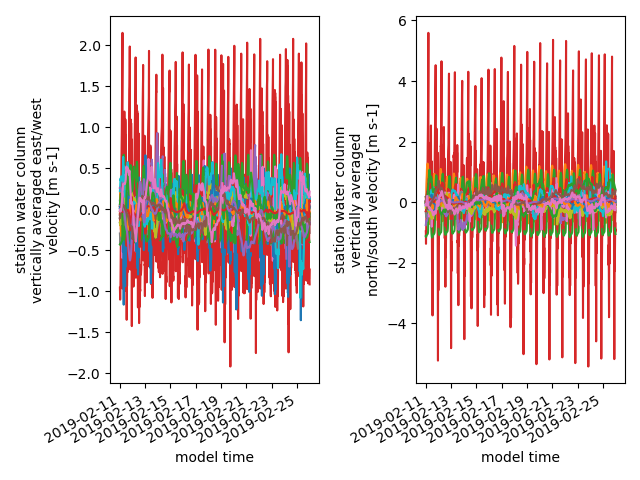

In [78]:
fig, ax = plt.subplots(1, 2)
for s in range(len(f62["station_name"])):
    f62.isel(station=s)["u-vel"].plot(ax=ax[0])
    f62.isel(station=s)["v-vel"].plot(ax=ax[1])
fig.tight_layout()

### Calculating Speed

In [73]:
f62["depth_avg_speed"] = np.sqrt(f62["u-vel"] ** 2 + f62["v-vel"] ** 2)

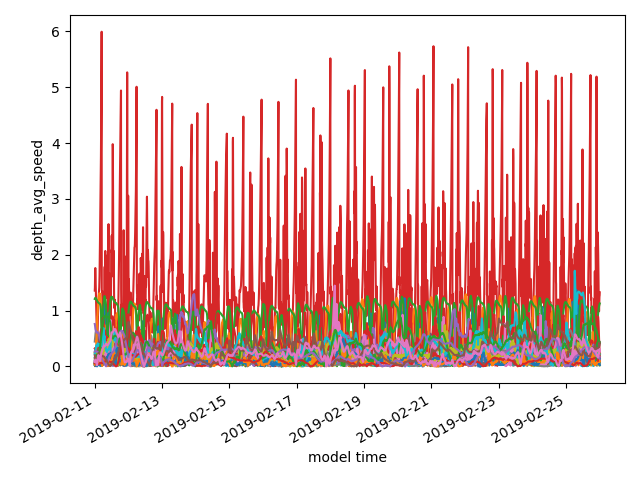

In [74]:
# This plot should show variability across every station
# Also no unreasonably high values (>4m across all stations)
fig, ax = plt.subplots(1, 1)
for s in range(len(f61["station_name"])):
    f62.isel(station=s)["depth_avg_speed"].plot(ax=ax)
fig.tight_layout()

### Station

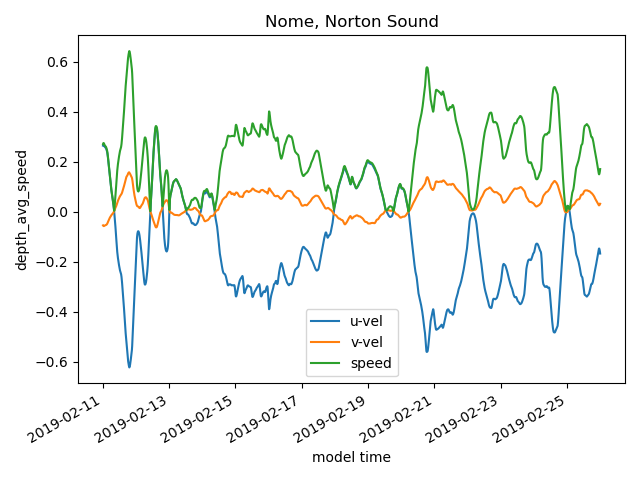

In [76]:
fig, ax = plt.subplots(1, 1)
f62.isel(station=station_idx)["u-vel"].plot(ax=ax, label="u-vel")
f62.isel(station=station_idx)["v-vel"].plot(ax=ax, label="v-vel")
f62.isel(station=station_idx)["depth_avg_speed"].plot(ax=ax, label="speed")
ax.legend()
ax.set_title(f"{noaa_station['name']}")
fig.tight_layout()

## F72,F73 - Station Atmospheric Forcing - Pressure and Wind

In [79]:
f71_path = get_file(v55, "fort.71.nc", "fort.71.nc")
f72_path = get_file(v55, "fort.72.nc", "fort.72.nc")
f71_path, f72_path

(PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2019/fort.71.nc'),
 PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/AK_Feb2019/fort.72.nc'))

In [80]:
f71 = xr.open_dataset(f71_path)
f72 = xr.open_dataset(f72_path)

In [81]:
f71

<xarray.Dataset>
Dimensions:       (time: 3600, station: 27)
Coordinates:
  * time          (time) datetime64[ns] 2019-02-11T00:06:00 ... 2019-02-26
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    pressure      (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        OceanMesh2D
    ...                 ...
    sfea0:              58.643293
    cf:                 0.0015
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               8

In [82]:
f72

<xarray.Dataset>
Dimensions:       (time: 3600, station: 27)
Coordinates:
  * time          (time) datetime64[ns] 2019-02-11T00:06:00 ... 2019-02-26
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    windx         (time, station) float64 ...
    windy         (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        OceanMesh2D
    ...                 ...
    sfea0:              58.643293
    cf:                 0.0015
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               8

### All Stations

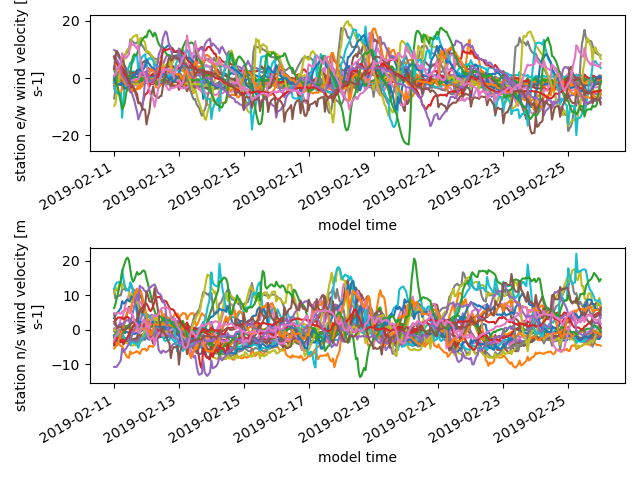

In [91]:
fig, ax = plt.subplots(2, 1)
for s in range(len(f72["station_name"])):
    f72.isel(station=s)["windx"].plot(ax=ax[0])
    f72.isel(station=s)["windy"].plot(ax=ax[1])
fig.tight_layout()

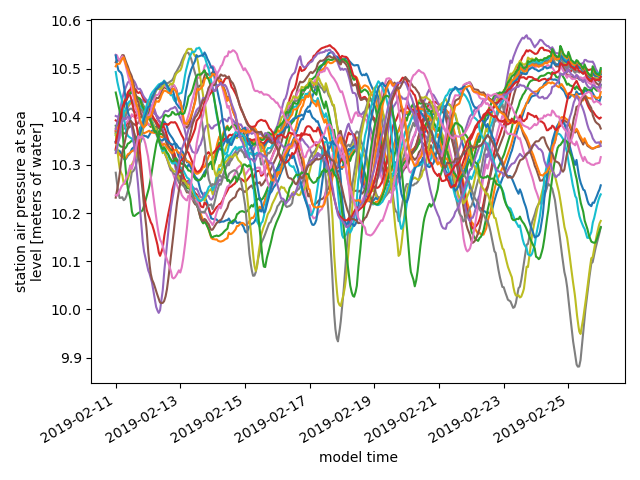

In [93]:
fig, ax = plt.subplots(1, 1)
for s in range(len(f72["station_name"])):
    f71.isel(station=s)["pressure"].plot(ax=ax)
fig.tight_layout()

### Wind Speed

In [86]:
f72["wind_speed"] = np.sqrt(f72["windx"] ** 2 + f72["windy"] ** 2)

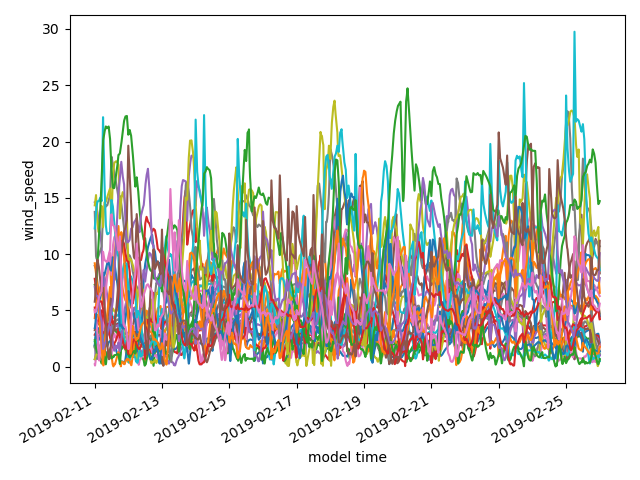

In [87]:
fig, ax = plt.subplots(1, 1)
for s in range(len(f72["station_name"])):
    f72.isel(station=s)["wind_speed"].plot(ax=ax)
fig.tight_layout()

### Station

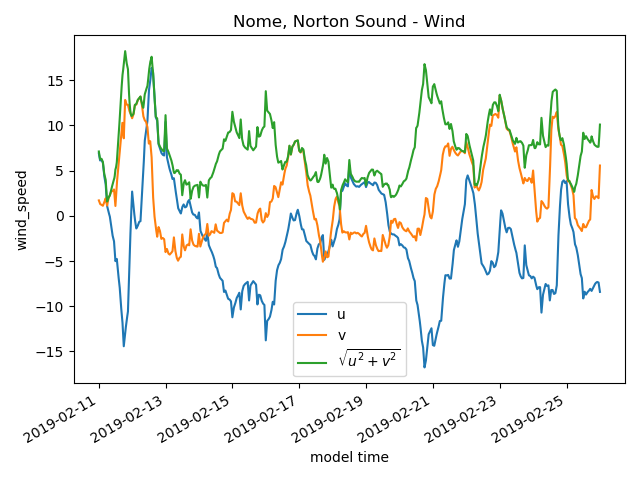

In [90]:
fig, ax = plt.subplots(1, 1)
f72.isel(station=station_idx)["windx"].plot(ax=ax, label="u")
f72.isel(station=station_idx)["windy"].plot(ax=ax, label="v")
f72.isel(station=station_idx)["wind_speed"].plot(ax=ax, label="$\sqrt{u^2+v^2}$")
ax.legend()
ax.set_title(f"{noaa_station['name']} - Wind")
fig.tight_layout()

# Beta Parameter Scan

In [16]:
from pathlib import Path
from typing import List

import numpy as np
from pyadcirc import io


def gen_uniform_beta_fort13(
    base_f13_path: str = "fort.13",
    targ_dir: str = None,
    name: str = "beta",
    num_samples: int = 10,
    domain: List[int] = [0.0, 2.0],
):
    """
    Generate fort.13 files w/beta vals from uniform distribution

    Parameters
    ----------
    base_f13_path : str, default='fort.13'
        Path to base fort.13 file to modify beta values for
    targ_dir : str, optional
        Path to output directory. Defaults to current working directory.
    name : str, default='beta'
        Name to give to output directory. Final name will be in the
        format {name}_{domain min}-{domain max}_u{num samples}
    num_samples : int, default=10
        Number of samples to take from a uniform distribution
    domain : List[int], default=[0.0, 2.0]
        Range for beta values.


    Returns
    ----------
    targ_path : str
        Path to directory containing all the seperate job directories
        with individual fort.13 files

    """

    targ_dir = Path.cwd() if targ_dir is None else targ_dir
    if not targ_dir.exists():
        raise ValueError(f"target directory {str(targ_dir)} does not exist")
    if not Path(base_f13_path).exists():
        raise ValueError(f"Unable to find base fort.13 file {base_f13_path}")

    targ_path = Path(
        f"{str(targ_dir)}/{name}_{domain[0]:.1f}-{domain[1]:.1f}_u{num_samples}"
    )
    targ_path.mkdir(exist_ok=True)

    beta_vals = np.random.uniform(domain[0], domain[1], size=num_samples)
    f13 = io.read_fort13(base_f13_path)

    for idx, b in enumerate(beta_vals):
        f13["v0"][0] = b
        job_name = f"beta-{idx}_{b:.2f}"
        job_dir = targ_path / job_name
        job_dir.mkdir(exist_ok=True)
        io.write_fort13(f13, str(job_dir / "fort.13"))

    return str(targ_path)

## Running Base Case

Make sure setting default value of 0.6 doesn't change anything. 

In [32]:
in_dir = scan_base_input_path
execs_dir = ls6_v55_beta
write_proc = 4

scan_base_job_config = {
    "name": "beta-base-ak_lw_feb2019_wind+ice",
    "app": "ls6_adcirc--0.0.0",
    "desc": (
        "ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55",
        "branch implementing nodal beta parameter for ice parametrization. ",
        "Using nodal attribute value but setting to default so should return ",
        "same time series.",
    ),
    "queue": "normal",
    "node_count": 5,
    "processors_per_node": 30,
    "memory_per_node": 0,
    "max_run_time": "00:30:00",
}
scan_base_job_config["inputs"] = {}
scan_base_job_config["parameters"] = {
    "inputDirectory": f"{in_dir}",
    "execDirectory": f"{execs_dir}",
    "writeProcesses": write_proc,
}
pp(scan_base_job_config)

{'app': 'ls6_adcirc--0.0.0',
 'desc': ('ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55',
          'branch implementing nodal beta parameter for ice parametrization. ',
          'Using nodal attribute value but setting to default so should '
          'return ',
          'same time series.'),
 'inputs': {},
 'max_run_time': '00:30:00',
 'memory_per_node': 0,
 'name': 'beta-base-ak_lw_feb2019_wind+ice',
 'node_count': 5,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/scans/Feb2019/CSFv2/base',
                'writeProcesses': 4},
 'processors_per_node': 30,
 'queue': 'normal'}


In [33]:
scan_base_job_config = tjm.deploy_job(jm, job_config=scan_base_job_config)
pp(scan_base_job_config)

{'app': 'ls6_adcirc--0.0.0',
 'desc': ['ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55',
          'branch implementing nodal beta parameter for ice parametrization. ',
          'Using nodal attribute value but setting to default so should '
          'return ',
          'same time series.'],
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-base-ak_lw_feb2019_wind+ice_20220210_143244',
 'job_id': 'beta-base-ak_lw_feb2019_wind+ice_20220210_143244',
 'max_run_time': '00:30:00',
 'memory_per_node': 0,
 'name': 'beta-base-ak_lw_feb2019_wind+ice',
 'node_count': 5,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/scans/Feb2019/CSFv2/base',
                'writeProcesses': 4},
 'processors_per_node': 30,
 'queue': 'normal'}


In [110]:
scan_base_job_config = tjm.submit_job(jm, job_id=scan_base_job_config["job_id"])
pp(scan_base_job_config)

{'app': 'ls6_adcirc--0.0.0',
 'desc': ['ADCIRC LW Mesh on LS6 with Feb2019 wind and ice data using v55',
          'branch implementing nodal beta parameter for ice parametrization. ',
          'Using nodal attribute value but setting to default so should '
          'return ',
          'same time series.'],
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/beta-base-ak_lw_feb2019_wind+ice_20220209_105226',
 'job_id': 'beta-base-ak_lw_feb2019_wind+ice_20220209_105226',
 'max_run_time': '00:30:00',
 'memory_per_node': 0,
 'name': 'beta-base-ak_lw_feb2019_wind+ice',
 'node_count': 5,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55_nodal_beta',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/Alaska/scans/Feb2019/CSFv2/base',
                'writeProcesses': 4},
 'processors_per_node': 30,
 'queue': 'normal',
 'slurm_id': '57929'}


In [111]:
tjm.get_queue(jm)

[{'job_id': '57929',
  'job_name': 'beta-base-',
  'username': 'clos21',
  'state': 'Running',
  'nodes': '5',
  'remaining': '5',
  'start_time': '0:29:57'}]

And we can peak at the end of the file to see how long the run is going

In [155]:
print(
    tjm.peak_file(
        jm, str(Path(scan_base_job_config["job_dir"]) / "output.eo.txt"), tail=20
    )
)

ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
INFO: owi_readNextSnap: Processing Oceanweather wind data for time stamp    190226000  0
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOutArrayNetCDF: No netCDF for files with unit number 91.
ERROR: writeOu

In [194]:
print(
    tjm.peak_file(
        jm,
        str(
            Path(submitted["job_dir"])
            / f"{submitted['job_id']}.e{submitted['slurm_id']}"
        ),
        tail=2,
    )
)

+ ibrun -np 4 ./padcirc -W 0
slurmstepd: error: *** JOB 50473 ON c302-005 CANCELLED AT 2022-02-03T18:03:25 DUE TO TIME LIMIT ***



## Creating Nodal Attribute Files

In [12]:
nodal_dir = ak_data_dir / "beta"
nodal_dir.mkdir(exist_ok=True)

f13_path = nodal_dir / "base.fort.13"

In [36]:
tjm.download(jm, scan_base_input_path / "fort.13", f13_path)

In [37]:
f13 = au.read_fort13(str(f13_path))
f13

<xarray.Dataset>
Dimensions:                                       (AttrName: 4, JN: 290660)
Coordinates:
  * AttrName                                      (AttrName) object 'beta' .....
  * JN                                            (JN) int64 1 2 ... 401143
Data variables:
    Units                                         (AttrName) object '1' ... '1'
    ValuesPerNode                                 (AttrName) int64 1 1 1 1
    v0                                            (AttrName) float64 0.6 ... ...
    beta_0                                        (JN) object nan nan ... nan
    primitive_weighting_in_continuity_equation_0  (JN) float64 0.02 0.02 ... nan
    internal_tide_friction_0                      (JN) float64 nan nan ... nan
    advection_state_0                             (JN) float64 nan nan ... 1e+05
Attributes:
    AGRID:       OceanMesh2D
    NumOfNodes:  443770
    NAttr:       4

In [38]:
f13["v0"].sel(AttrName="beta")

<xarray.DataArray 'v0' ()>
array(0.6)
Coordinates:
    AttrName  <U4 'beta'

In [39]:
beta_vals = np.arange(0.0, 2.0, 0.1)
beta_vals

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [41]:
for b in beta_vals:
    f13["v0"][0] = b
    job_dir = nodal_dir / f"beta_{b:.1f}"
    job_dir.mkdir(exist_ok=True)
    au.write_fort13(f13, str(job_dir / "fort.13"))

In [151]:
os.system(f"ls {nodal_dir}")

base.fort.13
beta_0.0_fort.13
beta_0.1_fort.13
beta_0.2_fort.13
beta_0.3_fort.13
beta_0.4_fort.13
beta_0.5_fort.13
beta_0.6_fort.13
beta_0.7_fort.13
beta_0.8_fort.13
beta_0.9_fort.13
beta_1.0_fort.13
beta_1.1_fort.13
beta_1.2_fort.13
beta_1.3_fort.13
beta_1.4_fort.13
beta_1.5_fort.13
beta_1.6_fort.13
beta_1.7_fort.13
beta_1.8_fort.13
beta_1.9_fort.13


0

In [154]:
tjm.upload(jm, str(nodal_dir), str(scan_base_input_path.parents[0]))

## Configuring pylauncher run